In [1]:
from cnn import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras import backend as K
from keras.optimizers import Adam

from PIL import Image
import numpy as np

Using TensorFlow backend.


### Read images and shuffle

In [2]:
data_dir_oil_wet = './32by32_SS2_OilWet/'
data_dir_water_wet = './32by32_SS2_WaterWet/'

In [3]:
num_images, dim_x = 800, 32

In [4]:
data_water_wet = np.zeros((num_images, dim_x, dim_x, 3))
data_oil_wet = np.zeros((num_images, dim_x, dim_x, 3))

In [5]:
for k in range(num_images):
    im_file = data_dir_water_wet + 'SS2_32by32_waterwet_%04d.tif' % (k+1)
    data_water_wet[k, ...] = np.array(Image.open(im_file))

In [6]:
for k in range(num_images):
    im_file = data_dir_oil_wet + 'SS2_32by32_oilwet_%04d.tif' % (k+1)
    data_oil_wet[k, ...] = np.array(Image.open(im_file))

In [7]:
data_water_wet.shape

(800, 32, 32, 3)

In [8]:
label_water_wet = np.ones((num_images,))
label_oil_wet = np.zeros((num_images,))

In [9]:
all_data_raw = np.append(data_water_wet, data_oil_wet, axis=0)
all_label_raw = np.append(label_water_wet, label_oil_wet, axis=0)

In [10]:
# np.random.seed(1)
randomize = np.array (np.arange(all_data_raw.shape[0]))
np.random.shuffle(randomize)
all_data = all_data_raw[randomize] / 255.
all_label = all_label_raw[randomize]

In [11]:
num_train, num_eval, num_test = 700*2, 100, 100

In [12]:
train_data = all_data[:num_train, ...]
train_label = all_label[:num_train]

In [13]:
eval_data = all_data[num_train:(num_train+num_eval), ...]
eval_label = all_label[num_train:(num_train+num_eval):]

In [14]:
test_data = all_data[-num_test:, ...]
test_label = all_label[-num_test:]

In [15]:
print(train_data.shape)
print(eval_data.shape)
print(test_data.shape)

(1400, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)


## Save data

In [16]:
import h5py

In [17]:
fn = h5py.File('rock_image_32x32.h5', 'w')
fn.create_dataset('train', data=train_data)
fn.create_dataset('train_label', data=test_label)
fn.create_dataset('eval', data=eval_data)
fn.create_dataset('eval_label', data=eval_label)
fn.create_dataset('test', data=test_data)
fn.create_dataset('test_label', data=test_label)
fn.close()

In [18]:
train_label.shape

(1400,)

### Plot images

In [19]:
import matplotlib.pyplot as plt

In [20]:
title_dict = {0.0: 'oil wet', 1.0: 'water wet'}

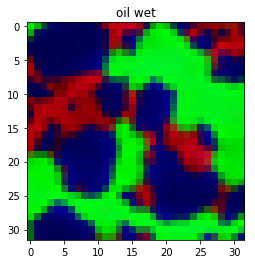

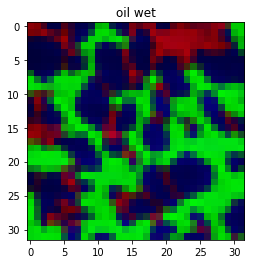

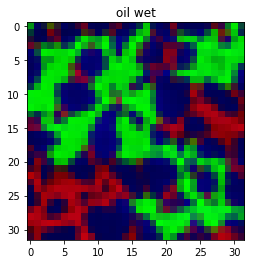

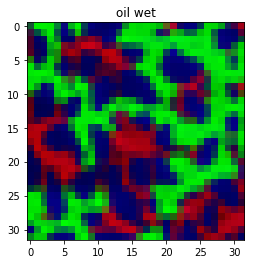

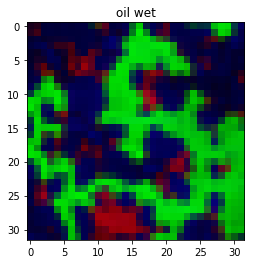

In [21]:
for k in range(5):
    plt.imshow(train_data[k, ...])
    plt.title(title_dict[train_label[k]])
    plt.show()

## Construct CNN

In [22]:
input_shape =(dim_x, dim_x, 3)
hidden_dim = 500
output_dim = 1

In [23]:
cnn_model = create_cnn(input_shape, hidden_dim, output_dim)

In [24]:
cnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 3)         84        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 3)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 3)         84        
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 3)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 3)           0         
__________

## Train the model

In [25]:
hist = cnn_model.fit(x=train_data, y=train_label, batch_size=50, epochs=50, validation_data=(eval_data, eval_label), verbose=True)

Train on 1400 samples, validate on 100 samples
Epoch 1/50
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6557 - acc: 0.6136 - val_loss: 0.5915 - val_acc: 0.6800
Epoch 2/50
1400/1400 [==============================] - 0s 176us/step - loss: 0.5658 - acc: 0.7386 - val_loss: 0.5299 - val_acc: 0.7400
Epoch 3/50
1400/1400 [==============================] - 0s 179us/step - loss: 0.5179 - acc: 0.7693 - val_loss: 0.4892 - val_acc: 0.7800
Epoch 4/50
1400/1400 [==============================] - 0s 187us/step - loss: 0.4797 - acc: 0.7893 - val_loss: 0.4483 - val_acc: 0.8200
Epoch 5/50
1400/1400 [==============================] - 0s 187us/step - loss: 0.4422 - acc: 0.8207 - val_loss: 0.4633 - val_acc: 0.7500
Epoch 6/50
1400/1400 [==============================] - 0s 185us/step - loss: 0.4134 - acc: 0.8314 - val_loss: 0.3747 - val_acc: 0.8300
Epoch 7/50
1400/1400 [==============================] - 0s 178us/step - loss: 0.3701 - acc: 0.8607 - val_loss: 0.3221 - val_acc: 0.8600
Epo

## Save trained model

In [26]:
cnn_model.save_weights('cnn_sandstone1_32x32.h5')

## Plot the training process

In [30]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

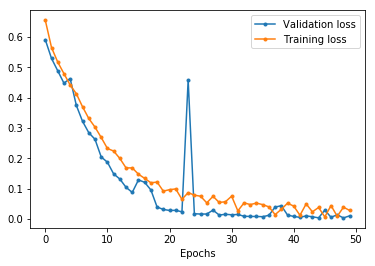

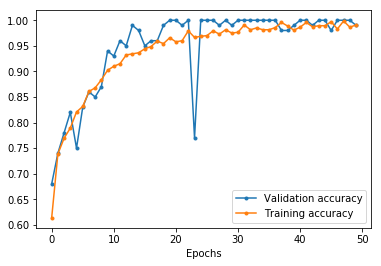

In [36]:
plt.plot(hist.history['val_loss'], marker='.')
plt.plot(hist.history['loss'], marker='.')
plt.legend(['Validation loss', 'Training loss'])
plt.xlabel('Epochs')
plt.figure()
plt.plot(hist.history['val_acc'], marker='.')
plt.plot(hist.history['acc'], marker='.')
plt.xlabel('Epochs')
plt.legend(['Validation accuracy', 'Training accuracy'])
plt.show()

In [37]:
import pickle

In [38]:
pickle.dump( hist.history, open( "hist_conv_sandstone1_32x32.pickle", "wb" ) )

## Plot the saliency map

In [76]:
test_data.shape

(100, 32, 32, 3)

In [77]:
saliency_data = test_data[:10, ...]
saliency_data.shape

(10, 32, 32, 3)

In [41]:
predicted_label = cnn_model.predict(saliency_data)

In [42]:
predicted_label

array([[5.497486e-07]], dtype=float32)

In [49]:
from keras.losses import binary_crossentropy
import keras.backend as K

cnn_model.output
true_label = K.placeholder(shape=(1,1))
# loss = binary_crossentropy(true_label, cnn_model.output)
# loss

<tf.Tensor 'Mean:0' shape=(?,) dtype=float32>

In [55]:
saliency = K.gradients(cnn_model.output, cnn_model.input)[0]

In [56]:
saliency

<tf.Tensor 'gradients_3/conv2d_1/convolution_grad/Conv2DBackpropInput:0' shape=(?, 32, 32, 3) dtype=float32>

In [58]:
saliency_evaluator = K.function([cnn_model.input], [saliency], updates=None)

In [78]:
saliency_map = saliency_evaluator([saliency_data])[0]

In [79]:
saliency_map = np.max(saliency_map, axis=3)
saliency_map.shape

(10, 32, 32)

In [72]:
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

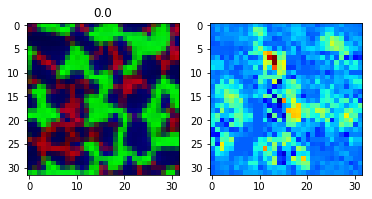

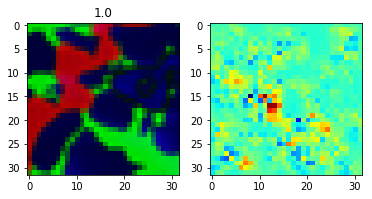

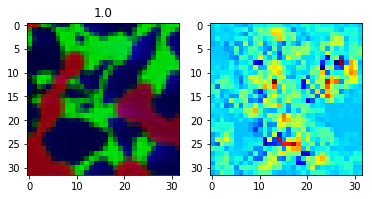

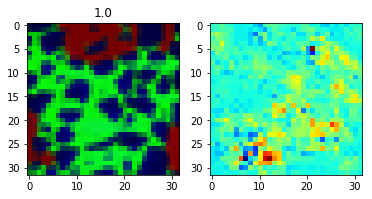

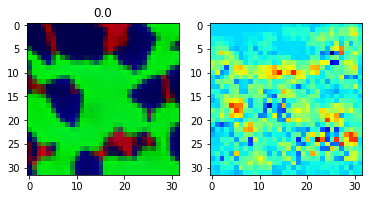

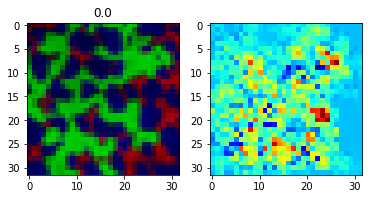

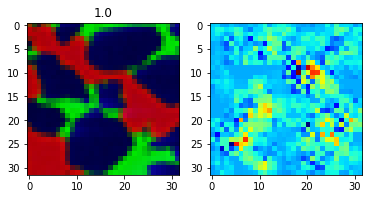

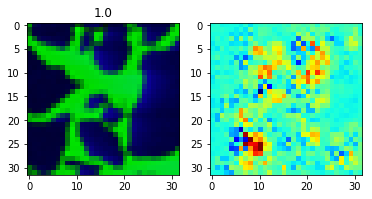

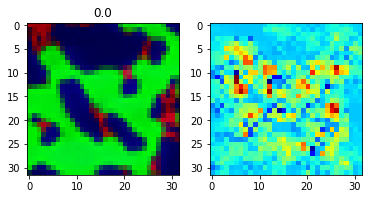

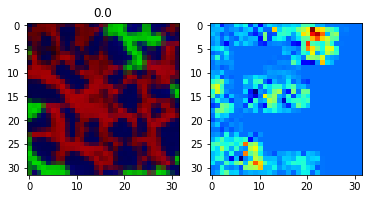

In [80]:
for k in range(10):
    plt.subplot(1,2,1)
    plt.imshow(saliency_data[k,...])
    plt.title(test_label[k])
    plt.subplot(1,2,2)
    plt.imshow(saliency_map[k,...])
    plt.show()


## Calculate accuracy on test set

In [23]:
test_label_predict = cnn_model.predict(test_data)

In [24]:
test_label_predict[np.where(test_label_predict>0.5)] = 1.0
test_label_predict[np.where(test_label_predict<=0.5)] = 0.0

In [25]:
for k in range(num_test):
    print('True label:%d. Predicted label %d.' % (test_label[k], test_label_predict[k]))
    if (test_label[k] != test_label_predict[k]):
        print("!!!!!!!!!!!!  == %d" % k)

True label:1. Predicted label 1.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:1. Predicted label 1.
True label:1. Predicted label 1.
True label:0. Predicted label 0.
True label:1. Predicted label 1.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:1. Predicted label 1.
True label:1. Predicted label 1.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:1. Predicted label 1.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:1. Predicted label 1.
True label:1. Predicted label 1.
True label:1. Predicted label 1.
True label:1. Predicted label 1.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:0. Predicted label 0.
True label:1. Predicted label 1.
True label:1. Predicted label 1.
True label

In [26]:
test_label.shape

(100,)

In [27]:
test_acc = np.sum(test_label.astype(int) == test_label_predict[:,0].astype(int)) / test_label.shape[0]

In [28]:
test_acc

1.0

## Plot result

True label 1, Predicted label 1


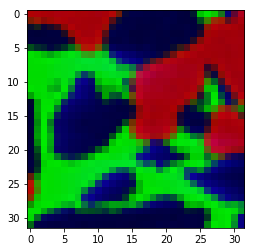

In [29]:
plt.imshow(test_data[58, ...])
print('True label %d, Predicted label %d' % (test_label[58], test_label_predict[58]))
plt.show()